<a href="https://colab.research.google.com/github/Nam-gu/MLB_Prediction/blob/main/Resnet/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/MLP_Prediction/MLB_Prediction/

/content/drive/MyDrive/MLP_Prediction/MLB_Prediction


In [96]:
file = './data/Retrosheet_2010_2019/2010_to_2019_seasons.csv'
game_df = pd.read_csv(file)

game_col_del = '''VisitorGDP,VisitorCI,HomeGDP,HomeCI, DoubleHeader, DayOfWeek, VisitingTeamLeague, HomeTeamLeague, DayNight, CompletionInfo,ForfeitInfo, ProtestInfo,Attendence, Duration, VisitorLineScore, HomeLineScore, UmpireHID, UmpireHName, Umpire1BID, Umpire1BName, Umpire2BID,Umpire2BName, Umpire3BID, Umpire3BName, UmpireLFID, UmpireLFName, UmpireRFID,UmpireRFName, VisitorManagerID, VisitorManagerName, HomeManagerID, HomeManagerName,WinningPitcherID, WinningPitcherName, LosingPitcherID, LosingPitcherNAme,SavingPitcherID, SavingPitcherName, GameWinningRBIID, GameWinningRBIName, VisitorBatting1Position, VisitorBatting2Position, VisitorBatting3Position,VisitorBatting4Position, VisitorBatting5Position, VisitorBatting6Position,VisitorBatting7Position, VisitorBatting8Position, VisitorBatting9Position,HomeBatting1Position, HomeBatting2Position, HomeBatting3Position,HomeBatting4Position, HomeBatting5Position, HomeBatting6Position,HomeBatting7Position, HomeBatting8Position, HomeBatting9Position,AdditionalInfo, AcquisitionInfo'''
game_col_del = game_col_del.replace(" ", "")
game_col_del = game_col_del.split(",")

game_df.drop(game_col_del,axis=1,inplace=True)


col_del = ['VisitorBatting1PlayerID', 'VisitorBatting1Name', 'VisitorBatting2PlayerID', 'VisitorBatting2Name', 'VisitorBatting3PlayerID', 'VisitorBatting3Name', 'VisitorBatting4PlayerID', 'VisitorBatting4Name', 'VisitorBatting5PlayerID', 'VisitorBatting5Name', 'VisitorBatting6PlayerID', 'VisitorBatting6Name', 'VisitorBatting7PlayerID', 'VisitorBatting7Name', 'VisitorBatting8PlayerID', 'VisitorBatting8Name', 'VisitorBatting9PlayerID', 'VisitorBatting9Name', 'HomeBatting1PlayerID', 'HomeBatting1Name', 'HomeBatting2PlayerID', 'HomeBatting2Name', 'HomeBatting3PlayerID', 'HomeBatting3Name', 'HomeBatting4PlayerID', 'HomeBatting4Name', 'HomeBatting5PlayerID', 'HomeBatting5Name', 'HomeBatting6PlayerID', 'HomeBatting6Name', 'HomeBatting7PlayerID', 'HomeBatting7Name', 'HomeBatting8PlayerID', 'HomeBatting8Name', 'HomeBatting9PlayerID', 'HomeBatting9Name']
game_df.drop(col_del,axis=1,inplace=True)
game_df = game_df.rename(columns={"VisitingTeam":"VisitorTeam","VisitingTeamGameNumber":"VisitorTeamGameNumber"})

In [97]:
away_inning = game_df['LengthInOuts']//2
home_inning = game_df['LengthInOuts']- away_inning


game_df['VisitorOffInn'] = away_inning
game_df['VisitorDifInn'] = home_inning
game_df['HomeOffInn'] = home_inning
game_df['HomeDifInn'] = away_inning

game_df['Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')
game_df['current_year'] = game_df['Date'].dt.year
game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']
game_df['Visitor_team_won?'] = game_df['HomeRunsScore'] < game_df['VisitorRunsScored']

In [98]:
bat_stat = [ 'TeamGameNumber','Team','AB','H','D','T','HR','RBI','SH','SF',
'HBP','BB','IBB','K','SB','CS','LOB','Pitchers',
'ER','TER','WP','Balks','PO','A','E','Passed','DB','TP','OffInn','DifInn','_team_won?']
pit_stat = ['H', 'D', 'T', 'HR', 'RBI', 'SH', 'SF', 'HBP', 'BB', 'IBB', 'K', 'LOB', 'ER','DB','AB']

In [99]:
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}

In [100]:
## Home 시각 
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}
Home = game_df.copy()
Home = Home[select_stat].rename(columns=rename1)
Home = Home.rename(columns=rename2)
# away 시각
select_stat = ['Date']
select_stat += ['Visitor'+i for i in bat_stat]+['Home'+i for i in pit_stat]
rename1 = {'Home'+i:'Pit'+i for i in pit_stat}
rename2 = {'Visitor'+i:i for i in bat_stat}
Visitor = game_df.copy()
Visitor = Visitor[select_stat].rename(columns=rename1)
Visitor = Visitor.rename(columns=rename2)

In [101]:
sep_team = pd.concat([Home,Visitor])
sep_team = sep_team.rename(columns={'PitDB':'DP'})

In [102]:
col = ['AB', 'H', 'D', 'T', 'HR', 'RBI','DP',
       'SF', 'BB', 'K', 'SB', 'CS', 'LOB', 'Pitchers', 'ER', 'TER', 'WP','PitAB',
       'Balks', 'PO', 'A', 'E', 'Passed', 'DB', 'TP', 'OffInn', 'DifInn',
       'PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF',
       'PitBB', 'PitK', 'PitLOB', 'PitER']

In [103]:
a = sep_team.copy()
sep_team['year']= sep_team.Date.dt.year
sep_team[col] = sep_team.groupby(['year','Team'])[col].transform(lambda x: x.expanding(1).sum())
sep_team[col] = sep_team[col].subtract(a[col])
sep_team = sep_team[sep_team['TeamGameNumber']>=10]

In [104]:
select_feature = ['Date', 'TeamGameNumber', 'Team','_team_won?']
# feature selection
select_feature += ['AB', 'H', 'D', 'T', 'HR', 'RBI','BB', 'K','DP', 'HBP','IBB','SF','SH',#bat stat
                    'ER','OffInn','DifInn' # game info
                    ,'PitAB','PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF', 'PitBB',"PitIBB","PitHBP" ,'PitK','PitLOB', 'PitER'
                    ]


In [114]:
sep = sep_team[select_feature] 

In [115]:
# H, OBP, SLG, ISO, Babip, RC, wOBA X, K, BB, RBI, K/B, HR   
# 타자 가공
sep['RC'] = ((sep['H']+sep['BB']+sep['HBP']-sep['DP'])
        *(sep['H']+2*sep['D']+3*sep['T']+4*sep['HR']+0.52*(sep['SF']+sep['SH'])+0.26*(sep['BB']+sep['HBP']-sep['IBB']))
        )/(sep['AB']*sep['AB']) #득점 생산


#사구,사사구, 고의사구 통합
sep['BB'] += sep['HBP']+sep['IBB']
sep['PitBB'] += sep['PitHBP']+sep['PitIBB']
#del sep['HBP'],sep['IBB'],sep['PitHBP'],sep['PitIBB']
# 희생번트, 희생플라이 통합
sep['PitSF'] += sep_team['PitSH']
sep['SF'] += sep['SH']
#del sep['SH'],sep['PitSH']

sep['K/B'] = sep['K']/(sep['BB']+0.5)
sep['PA'] = sep['AB'] - sep['BB'] - sep['SF'] # 타수
sep['Babip'] = (sep['H']+sep['D']+sep['T']) / (sep['PA']-sep['K']-sep['HR']-sep['SF']) # 인플레이 타구
sep['SLG'] = (sep['H']+2*sep['D']+3*sep['T']+4*sep['HR'])/sep['PA'] # 장타율
sep['H'] = sep['H']/sep['PA'] # 안타율
sep['D'] = sep['D']/sep['PA'] # 안타율
sep['T'] = sep['T']/sep['PA'] # 안타율
sep['HR'] = sep['HR']/sep['PA'] # 안타율
sep['BB'] = sep['BB']/sep['PA'] # 볼넷
sep['RBI'] = sep['RBI']/sep['TeamGameNumber'] # 득점
sep['K'] = sep['K']/sep['TeamGameNumber']

sep['OBP'] = (sep['H']+sep['BB']) #출루율
sep['OPS'] = sep['SLG']+sep['OBP'] #OPS
sep['GPA'] = (1.8*sep['OBP']+sep['SLG'])/4#GPA(Gross Production Average) - park factor를 적용해야함
sep['ISO'] = sep['SLG'] - sep['H']


In [116]:
# 투수 가공
# PitH, PitOBP, PitSLG, PitOPS, PitHR, EAR, PitB, PitK, PitK/B, WHIP, kwERA
sep['ERA'] = sep['PitER']/sep['DifInn']
sep['TotalH'] = sep['PitH']+sep['PitD']+sep['PitT']+sep['PitHR']
sep['TotalBB'] = sep['PitBB']+sep['PitHBP']
sep['PitPA'] = sep['PitAB'] - sep['TotalBB'] - sep['PitSF']
sep['kwERA'] = (5.40-12*(sep['PitK'] - sep['TotalBB']))/sep['PitPA']
sep['WHIP'] = (sep['TotalH']+sep['TotalBB'])/sep['DifInn']
sep['PitK'] = sep['PitK']/sep['DifInn']
sep['PitB'] = sep['TotalBB']/sep['DifInn']
sep['PitK/B'] = sep['PitK']/(sep['PitB']+0.5)


sep['PitSLG'] = (sep['PitH']+2*sep['PitD']+3*sep['PitT']+4*sep['PitHR'])/sep['PitPA'] # 피장타율
sep['PitH'] = sep['PitH']/sep['PitPA'] # 피안타율
sep['PitOBP'] = (sep['TotalH']+sep['TotalBB']) / sep['PitAB'] #피출루율
sep['PitOPS'] = sep['PitSLG']+sep['PitOBP'] #피OPS
sep['PitHR'] /= sep['PitPA']

In [ ]:
sep.max()

In [117]:

#temp = sep[['Date', 'TeamGameNumber', 'Team', '_team_won?','GPA', 'OPS','OBP','H','SLG','Babip','RC']]
temp = sep
game_log = game_df[['Date','VisitorTeam','HomeTeam','VisitorTeamGameNumber','HomeTeamGameNumber']]

game_log = game_log[game_log.VisitorTeamGameNumber>=10]
game_log = game_log[game_log.HomeTeamGameNumber>=10]

game_log = pd.merge(game_log,temp,left_on = ['Date','VisitorTeam'], right_on = ['Date','Team'],how='left')
game_log = pd.merge(game_log,temp,left_on = ['Date','HomeTeam'], right_on = ['Date','Team'],how='left')

game_log['year'] = game_log.Date.dt.year
train = game_log[game_log.year!=2019]
test = game_log[game_log.year==2019]

In [89]:
# 'H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','EAR','PitB','PitK','PitK/B','WHIP'

In [118]:
y_cols = ['_team_won?_x']
select = ['H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','ERA','PitB','PitK','PitK/B','WHIP']
#select = ['H', 'D', 'T', 'HR', 'RBI', 'BB']
x_cols = [i+'_x' for i in select]
x_cols += [i+'_y' for i in select]
train = train.dropna()
test = test.dropna()


In [119]:
y_train = train[y_cols]*1
y_test = test[y_cols]*1

X_train = train[x_cols]
X_test = test[x_cols]
x_ = [i+'_x' for i in select]
y_ = [i+'_y' for i in select]
'''
diff
X_train = X_train[x_].to_numpy() - X_train[y_].to_numpy()
X_test = X_test[x_].to_numpy() - X_test[y_].to_numpy()
'''

'''
div
X_train = np.log(X_train[x_].to_numpy()) - np.log(X_train[y_].to_numpy()+1e-6)
X_test = np.log(X_test[x_].to_numpy()) - np.log(X_test[y_].to_numpy()+1e-6)
'''

'\ndiv\nX_train = np.log(X_train[x_].to_numpy()) - np.log(X_train[y_].to_numpy()+1e-6)\nX_test = np.log(X_test[x_].to_numpy()) - np.log(X_test[y_].to_numpy()+1e-6)\n'

In [120]:
'''
    Z-score normalization
'''
scaler = StandardScaler()
scaler.fit(train[x_cols])
X_train = scaler.transform(train[x_cols])
X_test = scaler.transform(test[x_cols])

In [121]:
X_train = train[x_cols]
y_train = train[y_cols]*1

X_test = test[x_cols]
y_test = test[y_cols]*1

model = sm.Logit(y_train,X_train)
results = model.fit()
print(results.summary())

y_hat = results.predict(X_train)
y_hat = list(map(round,y_hat))
print('Train accuracy = ', accuracy_score(y_train, y_hat))

y_hat = results.predict( X_test)
y_hat = list(map(round,y_hat))
print('Test accuracy = ', accuracy_score(y_test, y_hat))

Optimization terminated successfully.
         Current function value: 0.679886
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           _team_won?_x   No. Observations:                21979
Model:                          Logit   Df Residuals:                    21943
Method:                           MLE   Df Model:                           35
Date:                Fri, 06 May 2022   Pseudo R-squ.:                 0.01527
Time:                        11:20:58   Log-Likelihood:                -14943.
converged:                       True   LL-Null:                       -15175.
Covariance Type:            nonrobust   LLR p-value:                 2.894e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H_x            5.7392   1.43e+06   4.02e-06      1.000    -2.8e+06     2.8e+06
OBP_x          3.4617   1.49e

In [122]:
X_train.max()

H_x          0.348694
OBP_x        0.459345
SLG_x        0.716082
ISO_x        0.386621
Babip_x      0.603349
RC_x         0.252742
K_x         80.600000
BB_x         0.151440
RBI_x       51.000000
K/B_x        3.928090
HR_x         0.061615
PitH_x       0.337559
PitOBP_x     0.508865
PitSLG_x     0.676929
PitOPS_x     1.182977
PitHR_x      0.057713
ERA_x        0.227355
PitB_x       0.157591
PitK_x       0.415983
PitK/B_x     0.695175
WHIP_x       0.695986
H_y          0.453488
OBP_y        0.656716
SLG_y        1.081395
ISO_y        0.627907
Babip_y      0.852459
RC_y         0.461939
K_y         10.220000
BB_y         0.328358
RBI_y        5.200000
K/B_y        7.818182
HR_y         0.081433
PitH_y       0.423529
PitOBP_y     0.636364
PitSLG_y     0.901961
PitOPS_y     1.526961
PitHR_y      0.096774
ERA_y        0.413333
PitB_y       0.265823
PitK_y       0.506667
PitK/B_y     0.915663
WHIP_y       0.938272
dtype: float64

In [123]:
num_thread = 8
# num of cpu 

In [ ]:
param ={'num_leaves':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
lgb =LGBMClassifier()
lgb_clf = GridSearchCV(lgb,param,scoring='accuracy',n_jobs=num_thread)
lgb_results = lgb_clf.fit(X_train, y_train.values.ravel(), eval_metric=['logloss'],eval_set=[(X_test, y_test.values.ravel())],callbacks=[lightgbm.early_stopping(10, verbose=0)])

train_score = lgb_results.score(X_train, y_train)
test_score = lgb_results.score(X_test, y_test)
print(lgb_results.best_params_)
print(test_score)

In [28]:
rf_param ={'min_samples_split':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
rf =RandomForestClassifier()
rf_clf = GridSearchCV(rf,rf_param,scoring='accuracy',n_jobs=num_thread)
rf_results = rf_clf.fit(X_train,  y_train.values.ravel())


train_score = rf_results.score(X_train, y_train)
test_score = rf_results.score(X_test, y_test)
print(rf_results.best_params_)
print(test_score)

{'max_depth': 6, 'min_samples_split': 10}
0.5783326621022956


In [26]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
svm_param  = [{'C': param_range, 'kernel': ['linear']}, {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]
svm_model =svm.SVC()
svm_clf = GridSearchCV(estimator=svm_model,param_grid=svm_param,scoring='accuracy',n_jobs=num_thread,verbose=0)
svm_results = svm_clf.fit(X_train, y_train.values.ravel())

train_score = svm_results.score(X_train, y_train)
test_score = svm_results.score(X_test, y_test)
print(svm_results.best_params_)
print(test_score)

KeyboardInterrupt: ignored

In [124]:
!pip install rtdl
!pip install libzero==0.0.4

In [156]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

device = torch.device("cuda:0")
zero.improve_reproducibility(seed=123456)

123456

In [155]:
norm_temp = np.concatenate([X_train, X_test])

from sklearn.preprocessing import RobustScaler

rob = RobustScaler()
norm_temp = rob.fit_transform(norm_temp)

In [157]:
X = {}
y = {}

y_train = sklearn.preprocessing.LabelEncoder().fit_transform(y_train).astype('int64')
y_test = sklearn.preprocessing.LabelEncoder().fit_transform(y_test).astype('int64')
X['train']=X_train
X['test']=X_test
y['train']=y_train
y['test']=y_test

preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

X['train']=torch.tensor(X['train'],dtype=torch.float32,device=device)
X['test']=torch.tensor(X['test'],dtype=torch.float32, device=device)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(X['train'], y['train'], train_size=0.8)

In [158]:
task_type ='binclass'
d_out = 1

model = rtdl.ResNet.make_baseline(
    d_in=X_train.shape[1],
    d_main=128,
    d_hidden=256,
    dropout_first=0.2,
    dropout_second=0.0,
    n_blocks=3,
    d_out=d_out,
)
lr = 0.001
weight_decay = 0.001

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)

loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [159]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score

batch_size = 64
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.4656


In [ ]:
n_epochs = 2000
report_frequency = len(X['train']) // batch_size // 5
loss_lst=[]
testacc=[]
valacc=[]
len_trainloader=len(train_loader)
for epoch in range(1, n_epochs + 1):
    avg_loss=0
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss=avg_loss / len_trainloader
    loss_lst.append(loss.item())
    val_score = evaluate('val')
    testacc.append(val_score)
    test_score = evaluate('test')
    valacc.append(test_score)
    print(f'Epoch {epoch:03d} | loss: {avg_loss:.4f} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}')
    # progress.update((-1 if task_type == 'regression' else 1) * val_score)
    # if progress.success:
    #     print(' <<< BEST VALIDATION EPOCH', end='')
    # print()
    # if progress.fail:
    #     break

Epoch 001 | loss: 0.6780 | Validation score: 0.5651 | Test score: 0.5904
Epoch 002 | loss: 0.6773 | Validation score: 0.5626 | Test score: 0.5840
Epoch 003 | loss: 0.6758 | Validation score: 0.5610 | Test score: 0.5868
Epoch 004 | loss: 0.6751 | Validation score: 0.5639 | Test score: 0.5828
Epoch 005 | loss: 0.6743 | Validation score: 0.5628 | Test score: 0.5759
Epoch 006 | loss: 0.6721 | Validation score: 0.5735 | Test score: 0.5844
Epoch 007 | loss: 0.6710 | Validation score: 0.5619 | Test score: 0.5755
Epoch 008 | loss: 0.6697 | Validation score: 0.5635 | Test score: 0.5775
Epoch 009 | loss: 0.6676 | Validation score: 0.5612 | Test score: 0.5860
Epoch 010 | loss: 0.6658 | Validation score: 0.5587 | Test score: 0.5787
Epoch 011 | loss: 0.6644 | Validation score: 0.5653 | Test score: 0.5775
Epoch 012 | loss: 0.6618 | Validation score: 0.5621 | Test score: 0.5715
Epoch 013 | loss: 0.6612 | Validation score: 0.5580 | Test score: 0.5747
Epoch 014 | loss: 0.6579 | Validation score: 0.5546

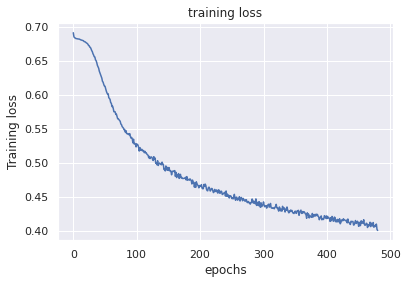

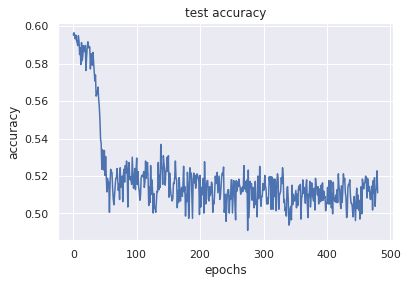

In [154]:
epoch_graph=np.arange(1,2001)

plt.plot(range(len(loss_lst)),loss_lst)
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('Training loss')
plt.show()

plt.plot(range(len(testacc)),testacc)
plt.title('test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()